# GNN: Graph Neural Networks

Author: Nicola Arici (nicola.arici@unibs.it)

In this exercise we will see the Graph Neural Networks and their implementation in Pytorch, with the Pytorch Geometric package (PyG). <br>

After an introduction to PyG, to understand how a graph is represented, we will see two tasks solved by GNN: a state classifier and a graph classifier.

---

### **Introduction to PyG (Pytorch Geometric)**

*Documentation:*

 - [PyG Documentation](https://pytorch-geometric.readthedocs.io/en/stable/index.html)
 - [PyG Tutorials](https://pytorch-geometric.readthedocs.io/en/stable/get_started/colabs.html)

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00


In [2]:
# Helper Functions for Visualization

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_graph(title, G, color, labels=None, train_mask=None, node_feature=False, edge_attr=None, node_size=100, img_size=(14, 14)):

    if edge_attr is not None:
        for i, (u, v) in enumerate(G.edges()):
            G[u][v]['weight'] = data.edge_attr[i].item()  # Assegna i pesi

    plt.figure(figsize=img_size)
    plt.title(title)

    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos, with_labels=node_feature, node_size=node_size, node_color=color, cmap="Set2")

    # Train mask.
    if train_mask is not None:
        nx.draw_networkx_nodes(G, pos=pos,
                        nodelist=[i for i, t in enumerate(train_mask) if t],
                        node_color=[c for c, t in zip(color, train_mask) if t],
                        cmap="Set2", edgecolors='red', linewidths=2,node_size=node_size)

    # Draw edge weights
    edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming 'weight' is the attribute name
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Make Legend.
    if labels is not None:
        scatter = plt.scatter(np.zeros(len(labels)), np.zeros(len(labels)), c=np.arange(len(labels)), s=0, cmap="Set2")
        plt.legend(handles=scatter.legend_elements()[0], labels=labels.values())

    plt.show()


def visualize_embedding(title, h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.legend(handles=scatter.legend_elements()[0], labels=labels.values())
    plt.show()


**Graph Notation**

Construct the following graph with PyG:

<img src="https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg" width="600px" style="background-color: white;">

In [3]:
import torch
from torch_geometric.data import Data

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.float)


y = torch.tensor([0, 1, 0], dtype=torch.float)

data = Data(x, edge_index=edge_index, y=y)

data

Data(x=[3, 1], edge_index=[2, 4], y=[3])

In [4]:
data.validate(raise_on_error=True)

True

**Gather some statistics about the graph**

In [5]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of Edge Features: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 3
Number of edges: 4
Number of Edge Features: 0
Average node degree: 1.33
Has isolated nodes: False
Has self-loops: False
Is undirected: True


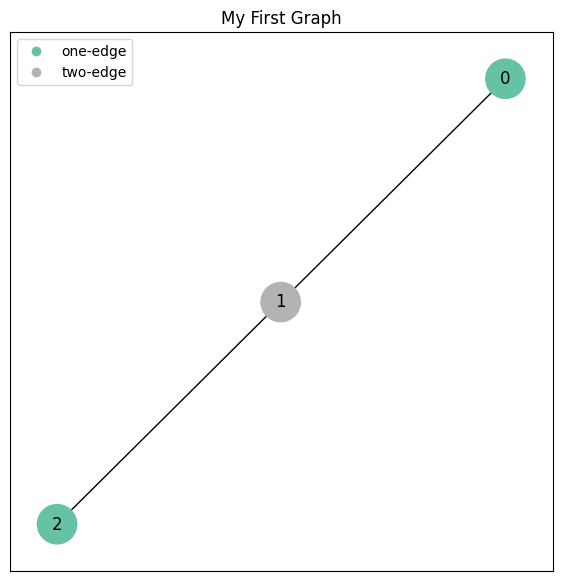

In [6]:
from torch_geometric.utils import to_networkx

labels = {0: 'one-edge', 1: 'two-edge'}

visualize_graph("My First Graph",
                to_networkx(data, to_undirected=data.is_undirected()),
                color=data.y,
                labels=labels,
                node_feature=True,
                edge_attr=data.edge_attr,
                node_size=800,
                img_size=(7, 7))


---

### **A Real Example**

A social network of a karate club was studied for a period of three years from 1970 to 1972 [(Zachary, 1977)](https://www.jstor.org/stable/3629752?seq=1). The network captures **34** members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi", which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate.

In the first version of the dataset, each node is labelled with the group to which it belongs. In this case we implement the second version, in which every node is labeled by one of **four** classes obtained via modularity-based clustering by <a href="https://arxiv.org/abs/1609.02907"><i>Kipf et al. (2016)</i></a>

*Documentation:*

 - [PyG Dataset](https://pytorch-geometric.readthedocs.io/en/stable/modules/datasets.html)
 - [PyG Transforms](https://pytorch-geometric.readthedocs.io/en/stable/modules/transforms.html)

In [7]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'')

data = dataset[0]

print()
print(data)
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of Edge Features: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('===========================================================================================================')
print(f'Number of training nodes: {data.train_mask.sum()} - {100*(data.train_mask.sum()) / data.num_nodes:.2f}%')
print('===========================================================================================================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Number of Edge Features: 0
Average node degree: 4.59
Number of training nodes: 4 - 11.76%
Has isolated nodes: False
Has self-loops: False
Is undirected: True


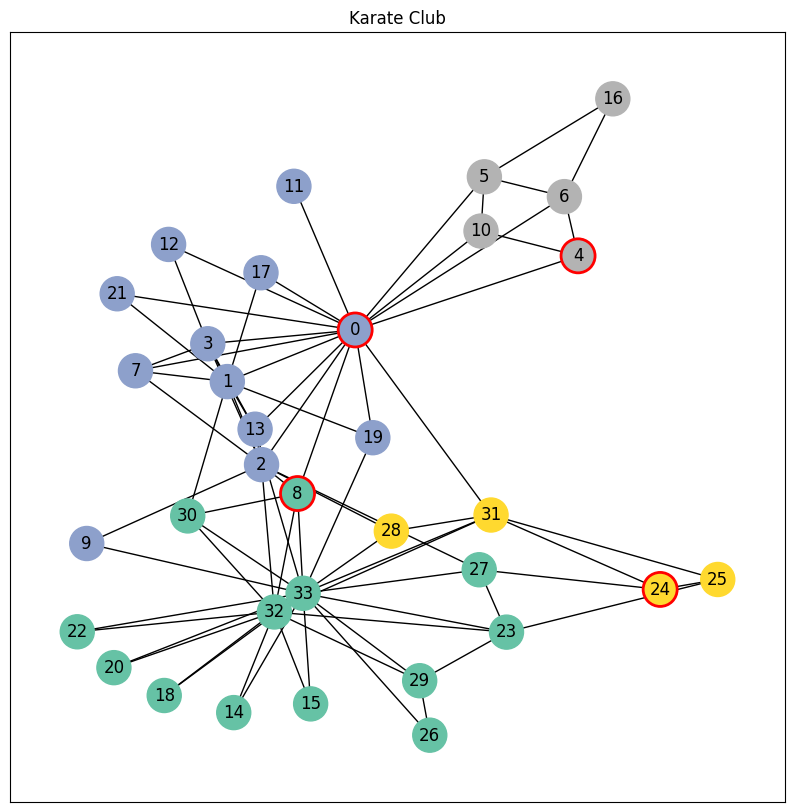

In [8]:
from torch_geometric.utils import to_networkx

visualize_graph("Karate Club",
                to_networkx(dataset[0], to_undirected=data.is_undirected()),
                node_feature=True,
                color=data.y,
                train_mask=data.train_mask.numpy(),
                node_size=600,
                img_size=(10, 10))


---

### **Node Classification with Graph Neural Networks**

The Cora dataset ([McCallum et al. (2000)](https://link.springer.com/article/10.1023/A:1009953814988)) consists of **2708** scientific publications classified into one of **seven** classes, following the topic disccusesd. <br>
The citation network consists of **5429** links. <br>
Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of **1433** unique words.

In [9]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of Edge Features: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('===========================================================================================================')
print(f'Number of training nodes: {data.train_mask.sum()} - {100*(data.train_mask.sum()) / data.num_nodes:.2f}%')
print(f'Number of validation nodes: {data.val_mask.sum()}  - {100*(data.val_mask.sum()) / data.num_nodes:.2f}%')
print(f'Number of testing nodes: {data.test_mask.sum()}  - {100*(data.test_mask.sum()) / data.num_nodes:.2f}%')
print('===========================================================================================================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of Edge Features: 0
Average node degree: 3.90
Number of training nodes: 140 - 5.17%
Number of validation nodes: 500  - 18.46%
Number of testing nodes: 1000  - 36.93%
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


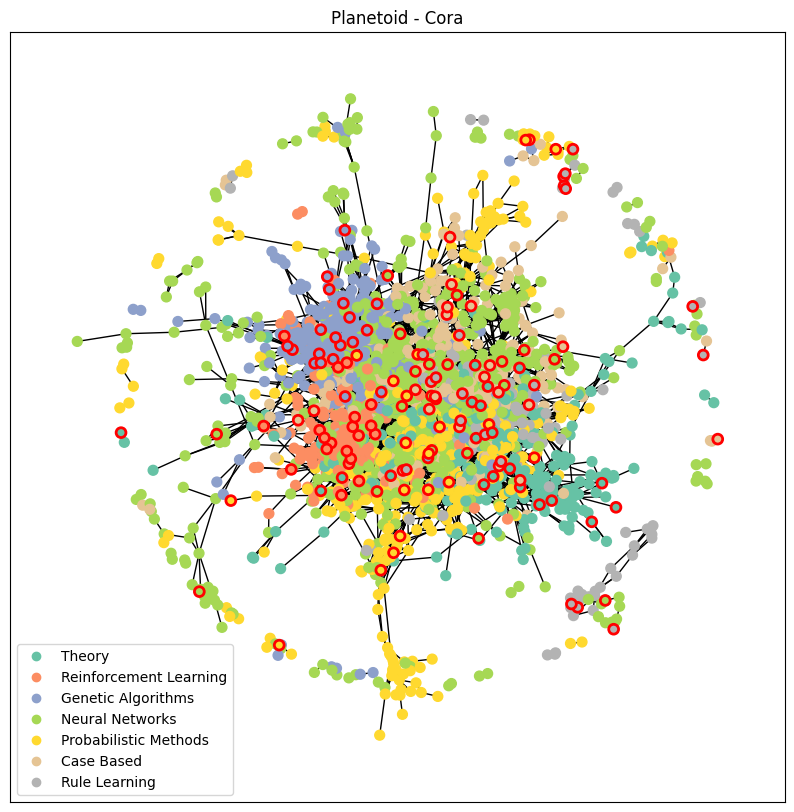

In [10]:
from torch_geometric.utils import to_networkx

label_dict = {
    0: "Theory",
    1: "Reinforcement Learning",
    2: "Genetic Algorithms",
    3: "Neural Networks",
    4: "Probabilistic Methods",
    5: "Case Based",
    6: "Rule Learning"
}

visualize_graph("Planetoid - Cora",
                to_networkx(dataset[0], to_undirected=dataset[0].is_undirected()),
                color=data.y,
                labels=label_dict,
                train_mask=data.train_mask.numpy(),
                node_size=50,
                img_size=(10, 10))

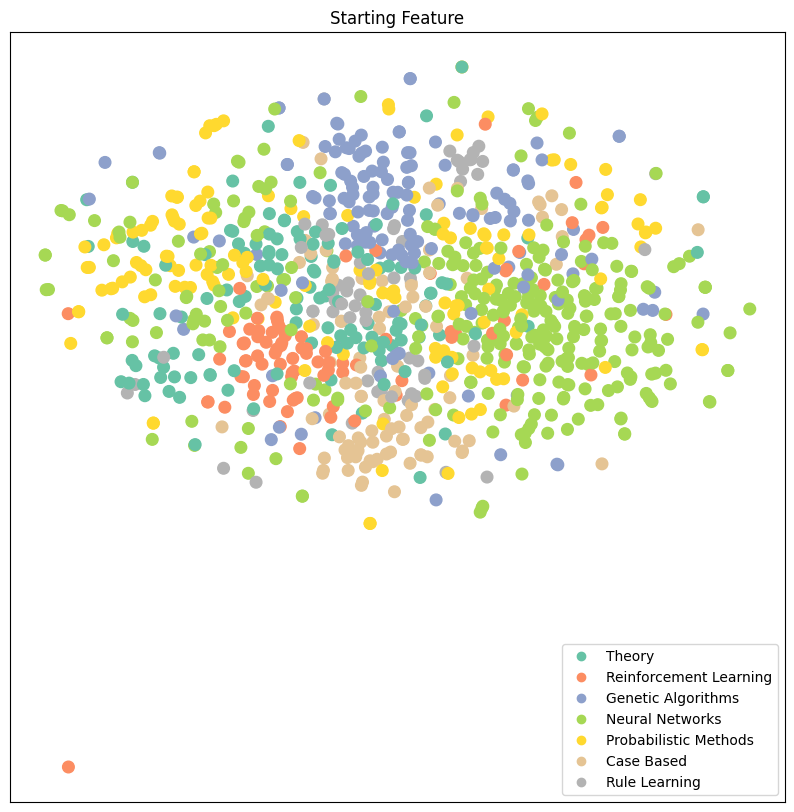

In [11]:
visualize_embedding("Starting Feature", data.x[data.test_mask], color=data.y[data.test_mask], labels=label_dict)

Let's build our first GCN for node classification

*Documentation*:

 - [PyG nn](https://pytorch-geometric.readthedocs.io/en/stable/modules/nn.html)
 - [PyG GCNCovn](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.conv.GCNConv.html)
 - [Kipf and Welling (2016)](https://arxiv.org/abs/1609.02907)

In [12]:
import os
import torch
import random
import numpy as np

SEED = 124567

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [13]:
import os
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score


SAVE_DIR = "./gnn/"
MODEL_NAME = "node_cls.pth"


class NodeClassificator(nn.Module):

    def __init__(self, dataset, device, hidden_state):
      super(NodeClassificator, self).__init__()

      self.device = device

      self.graph = dataset[0].to(device)

      self.conv1 = GCNConv(dataset.num_features, hidden_state)
      self.conv2 = GCNConv(hidden_state, dataset.num_classes)

      self.dropout = nn.Dropout(p=0.5)

      self.relu = nn.ReLU()

    def forward(self, x, edge_index):

      hidden = self.relu(self.conv1(x, edge_index))
      out = self.conv2(self.dropout(hidden), edge_index)

      return out


    def train_gcn(self, num_epochs, optim, criterion):

        train_loss = []
        val_losses = []
        val_accs = []
        best_val_acc = 0
        best_epoch = 0

        for ep in tqdm(range(num_epochs)):
            self.train()

            optim.zero_grad()

            out = self(self.graph.x, self.graph.edge_index)

            loss = criterion(out[self.graph.train_mask], self.graph.y[self.graph.train_mask])

            loss.backward()
            optim.step()

            val_loss, val_acc = self.eval_gcn(criterion)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = ep

                if not os.path.exists(SAVE_DIR):
                    os.mkdir(SAVE_DIR)

                torch.save(self.state_dict(), os.path.join(SAVE_DIR, MODEL_NAME))

            train_loss.append(loss.item())
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        print(f"Saved best model at epoch {best_epoch} with val acc {round(best_val_acc*100, 2)}")
        return train_loss, val_losses, val_accs


    @torch.no_grad()
    def eval_gcn(self, criterion):
        self.eval()

        out = self(self.graph.x, self.graph.edge_index)
        pred = out.argmax(dim=1)

        val_loss = criterion(out[self.graph.val_mask], self.graph.y[self.graph.val_mask]).cpu().item()

        return val_loss, accuracy_score(self.graph.y[self.graph.val_mask].cpu(), pred[self.graph.val_mask].cpu())


    @torch.no_grad()
    def predict(self):
        self.eval()

        with torch.no_grad():
            out = self(self.graph.x, self.graph.edge_index)

        preds = out[self.graph.test_mask].argmax(dim=1).cpu().numpy().tolist()
        lbls = self.graph.y[self.graph.test_mask].cpu().numpy().tolist()
        out = out[self.graph.test_mask]

        return preds, lbls, out

In [14]:
from torch.optim import Adam

!mkdir -p gnn

NUM_EPOCHS = 200
HIDDEN_STATE = 64
LR = 0.01


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gcn = NodeClassificator(dataset, device, HIDDEN_STATE).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(gcn.parameters(), lr=LR)

train_loss, eval_losses, eval_accs = gcn.train_gcn(NUM_EPOCHS, optimizer, criterion)

100%|██████████| 200/200 [00:02<00:00, 82.10it/s] 

Saved best model at epoch 45 with val acc 80.2


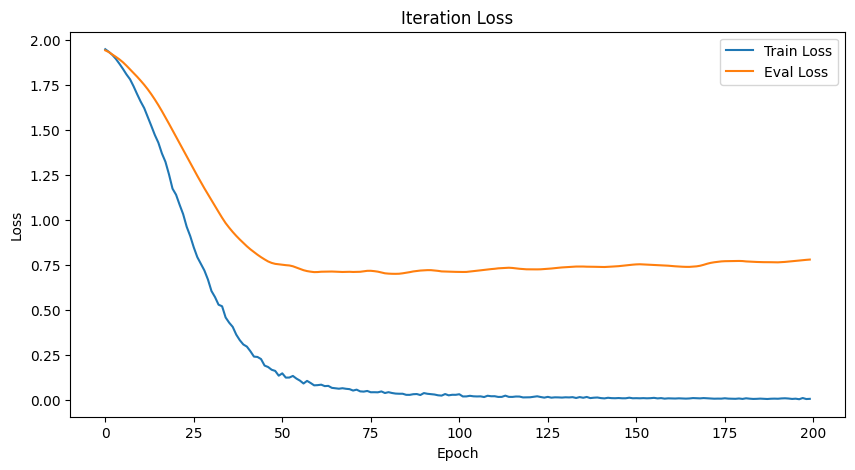

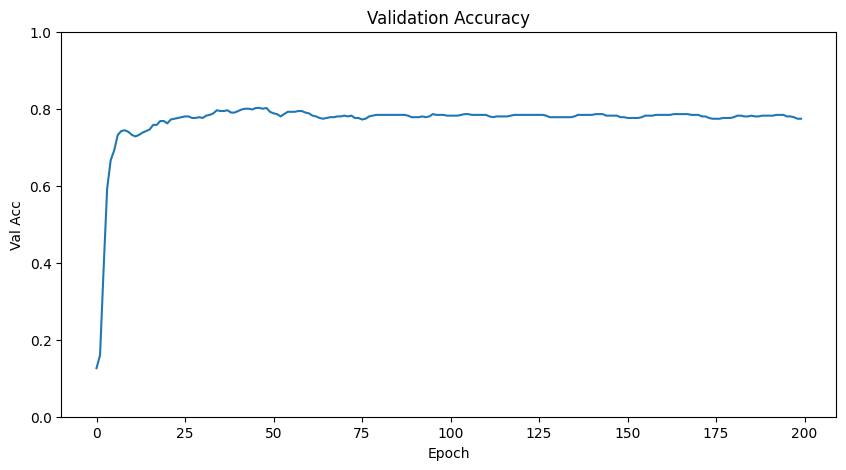

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Iteration Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eval_accs)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Val Acc")
plt.title("Validation Accuracy")
plt.show()

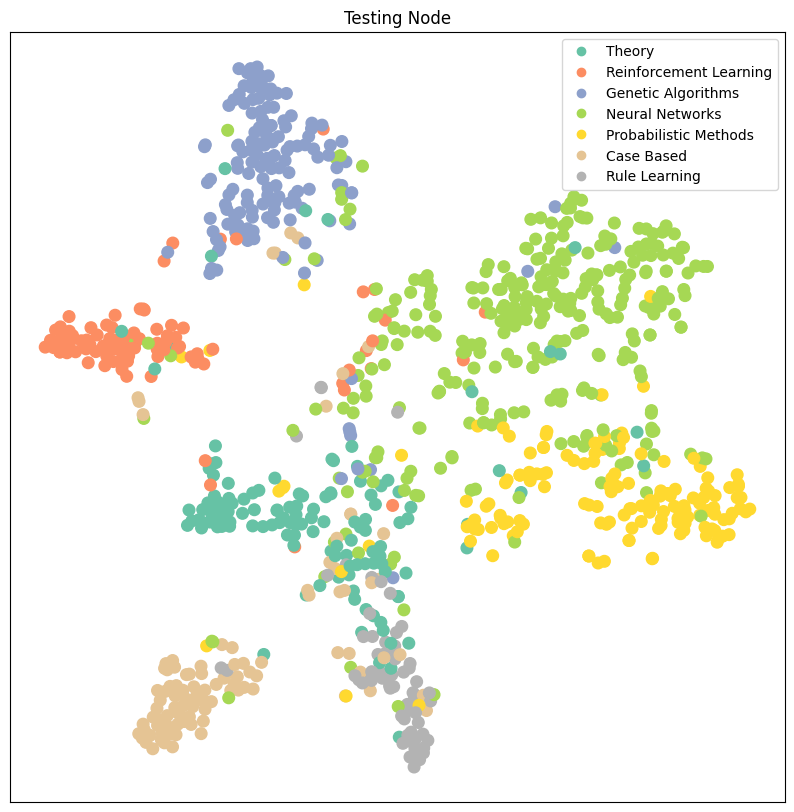

                        precision    recall  f1-score   support

                Theory       0.68      0.83      0.74       130
Reinforcement Learning       0.78      0.88      0.82        91
    Genetic Algorithms       0.85      0.91      0.88       144
       Neural Networks       0.94      0.77      0.85       319
 Probabilistic Methods       0.82      0.87      0.84       149
            Case Based       0.83      0.74      0.78       103
         Rule Learning       0.73      0.80      0.76        64

              accuracy                           0.82      1000
             macro avg       0.80      0.83      0.81      1000
          weighted avg       0.83      0.82      0.82      1000



In [16]:
from sklearn.metrics import classification_report

gcn.load_state_dict(torch.load(os.path.join(SAVE_DIR, MODEL_NAME), weights_only=False, map_location=device))
preds, lbls, embs = gcn.predict()

visualize_embedding("Testing Node", embs, color=lbls, labels=label_dict)
print(classification_report(lbls, preds, zero_division=0, target_names=label_dict.values()))


---

### **Graph Classification with Graph Neural Networks**

Mutagenicity ([Zhang et al. (2019)](https://arxiv.org/abs/1911.05954)) is a chemical compound dataset of **4337** drugs, which can be categorized into **two** classes: mutagen and non-mutagen.<br>
For each graph, nodes represent single atoms and arcs represent bonds (without distinction). The dataset contains **14** unique atoms (*Carbon, Oxigen, Chlorine, Hydrogen, Nitrogen, Fluorite, Bromine, Sulfur, Phosphorus, Iodine, Sodium, Potassium, Lithium, Calcium*) and each node is represented by a one-hot vector.

In [17]:
# Helper Functions for visualization


def to_molecule(pyg_graph):
    g = to_networkx(pyg_graph, node_attrs=['x'])
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    EDGE_MAP = [1, 2, 3]

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']

    for i, (u, v) in enumerate(g.edges()):
        g[u][v]['weight'] = EDGE_MAP[torch.argmax(pyg_graph.edge_attr[i]).item()]  # Assegna i pesi

    return g


def draw_molecule(g, edge_mask=None):

    plt.figure(figsize=(10, 5))

    g = g.copy().to_undirected()

    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']

    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)

    widths = [g[u][v]['weight'] ** 2 for u, v in g.edges()]

    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color='black', node_size=300, node_color='lightblue')

    plt.show()

In [18]:
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures

dataset = TUDataset(root='data/TUDataset', name='Mutagenicity', transform=NormalizeFeatures())

tn, te = 0, 0
for d in dataset: tn += d.num_nodes; te += d.num_edges

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node per graph: {tn / len(dataset):.2f}')
print(f'Number of edge per graph: {te / len(dataset):.2f}')

data = dataset[0]

print()
print(data)
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of Edge Features: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('===========================================================================================================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Number of node per graph: 30.32
Number of edge per graph: 61.54

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Number of nodes: 16
Number of edges: 32
Number of Edge Features: 3
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


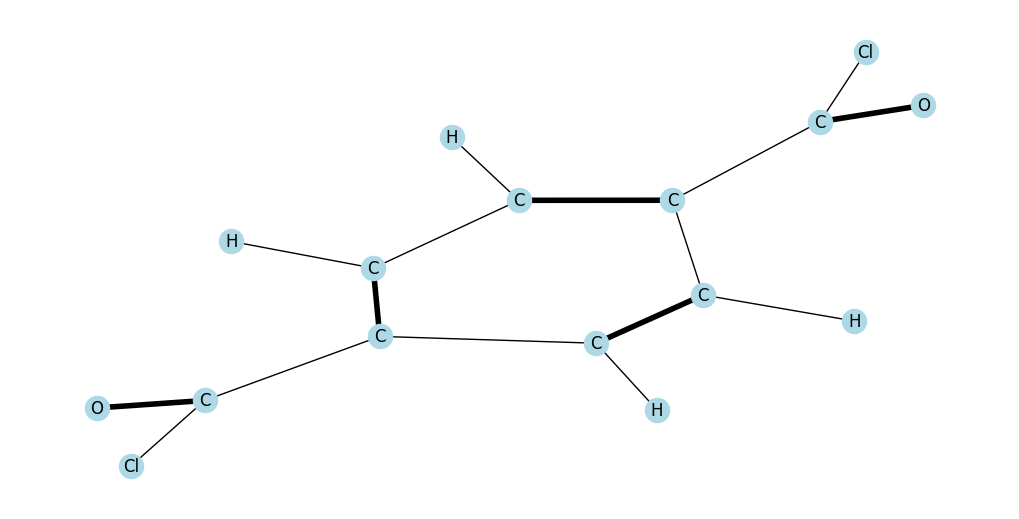

In [19]:
draw_molecule(to_molecule(data))

In [20]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64

dataset = dataset.shuffle()

train_dataset = dataset[:round(len(dataset)*0.8)]
val_dataset = dataset[round(len(dataset)*0.8):round(len(dataset)*0.9)]
test_dataset = dataset[round(len(dataset)*0.9):]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print()
print("First Batch:")
print(next(iter(train_loader)))

Number of training graphs: 3470
Number of val graphs: 433
Number of test graphs: 434

First Batch:
DataBatch(edge_index=[2, 4148], x=[2025, 14], edge_attr=[4148, 3], y=[64], batch=[2025], ptr=[65])


Let's build the second GCN, in this case for graph classification.

*Documentation*:

 - [PyG GatedGraphConv](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.conv.GatedGraphConv.html?highlight=Gated)
 - [Li et al. (2015)](https://arxiv.org/abs/1511.05493)

In [21]:
from torch_geometric.nn import GatedGraphConv, global_mean_pool, BatchNorm


MODEL_NAME = "graph_cls.pth"

class GraphConvNet(nn.Module):

    def __init__(self, dataset, device, hidden_state, num_layers):
        super(GraphConvNet, self).__init__()

        self.device = device

        self.conv = GatedGraphConv(hidden_state, num_layers)

        self.linear1 = nn.Linear(hidden_state, hidden_state)
        self.linear2 = nn.Linear(hidden_state, dataset.num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=1)


    def forward(self, x, edge_index, batch):

        hidden = self.relu(self.conv(x, edge_index=edge_index))

        hidden = global_mean_pool(hidden, batch)

        hidden = self.relu(self.linear1(hidden))

        hidden = self.linear2(self.dropout(hidden))

        return self.softmax(hidden)

    def train_gcn(self, train_loader, val_loader, num_epochs, optim, criterion):

        train_loss = []
        val_losses = []
        val_accs = []
        best_val_loss = np.inf
        best_epoch = 0

        for ep in tqdm(range(num_epochs)):
            self.train()

            for data in train_loader:

                data = data.to(self.device)
                optim.zero_grad()


                out = self(data.x, data.edge_index, data.batch)

                loss = criterion(out, data.y)

                loss.backward()
                optim.step()


            val_loss, val_acc = self.eval_gcn(val_loader, criterion)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = ep

                if not os.path.exists(SAVE_DIR):
                    os.mkdir(SAVE_DIR)

                torch.save(self.state_dict(), SAVE_DIR + MODEL_NAME)

            train_loss.append(loss.item())
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        print(f"Saved best model at epoch {best_epoch} with val loss {round(best_val_loss, 4)}")
        return train_loss, val_losses, val_accs


    @torch.no_grad()
    def eval_gcn(self, val_loader, criterion):
        self.eval()

        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                data = data.to(self.device)

                out = self(data.x, data.edge_index, data.batch)
                val_preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
                val_labels.extend(data.y.cpu().numpy().tolist())

                val_loss += criterion(out, data.y).cpu().item()

        return val_loss / len(val_loader), accuracy_score(val_labels, val_preds)


    @torch.no_grad()
    def predict(self, test_loader):
        self.eval()

        test_preds = []
        test_labels = []

        with torch.no_grad():
            for data in test_loader:
                data = data.to(self.device)

                out = self(data.x, data.edge_index, data.batch)
                test_preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
                test_labels.extend(data.y.cpu().numpy().tolist())

        return test_preds, test_labels

In [22]:
NUM_EPOCHS = 200
HIDDEN_STATE = 128
NUM_LAYERS = 5
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gcn = GraphConvNet(dataset, device, HIDDEN_STATE, NUM_LAYERS).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = Adam(gcn.parameters(), lr=LR)

train_loss, eval_losses, eval_accs = gcn.train_gcn(train_loader, val_loader, NUM_EPOCHS, optimizer, criterion)

100%|██████████| 200/200 [02:22<00:00,  1.40it/s]

Saved best model at epoch 153 with val loss 0.485


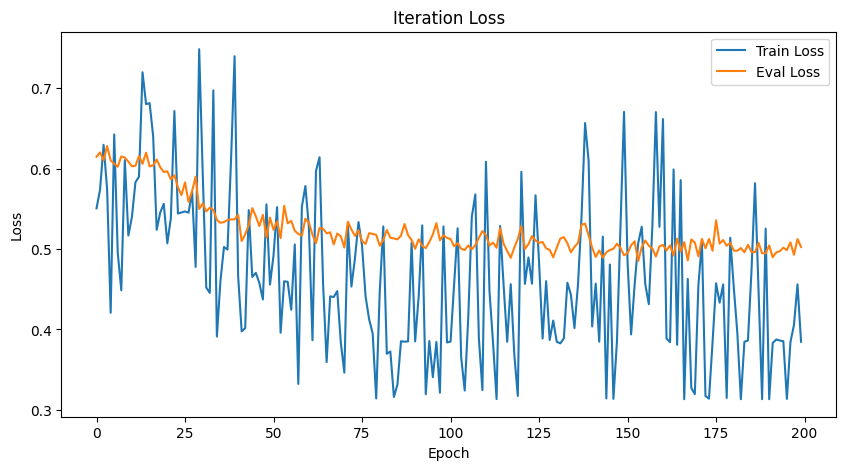

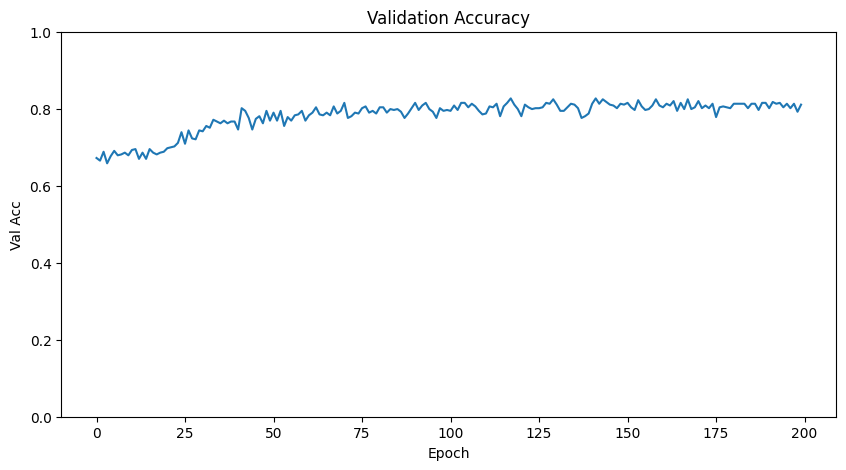

In [23]:
# Plotting

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Iteration Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eval_accs)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Val Acc")
plt.title("Validation Accuracy")
plt.show()

In [24]:
gcn.load_state_dict(torch.load(os.path.join(SAVE_DIR, MODEL_NAME), weights_only=False, map_location=device))
preds, lbls = gcn.predict(test_loader)

print(classification_report(lbls, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       236
           1       0.84      0.78      0.81       198

    accuracy                           0.83       434
   macro avg       0.83      0.83      0.83       434
weighted avg       0.83      0.83      0.83       434




---

### **Improve the results**

You can implement the same architecture and solve the same task with different GNN:

 - [GAT - Graph Attention Network](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html?highlight=gat#torch_geometric.nn.models.GAT) [(Veličković et al. (2017)](https://arxiv.org/abs/1710.10903)

 - [GTN - Graph Transformer Networks (Yun et al. (2017)](https://arxiv.org/pdf/1703.10717.pdf)
